In [ ]:
# install pandas_datareader for Up-to-date remote data access for pandas
# and yfinance for market data from Yahoo!
!pip install --upgrade pandas_datareader
!pip install --upgrade yfinance

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr # gets yahoo specific data
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf
import os

path = os.getcwd()
print(path)

/Users/ianpadilla/MC_Stock_Portfolio


# Monte Carlo Simulation of Stock Portfolio

**Monte Carlo (MC):** Computational simulations that rely on a *repeated random sampling* to estimate numerical results.

Solution is not deterministic. If we place the same input in more complex models with different underlying distributions (non-normal multi-variate distributions). No exact mathematical solutions. We rely on MC simulations by repeately drawing random samples from a normal distribution.

In [9]:
# import historical data
def getData(stocks, start, end):
    """
    returns mean returns and covariance matrix for whatever stocks
    we put in there for a given time range start->end
    """
    stockData = pdr.get_data_yahoo(stocks, start, end) # takes in stocks and time range
    stockData = stockData['Close'] # dataframe with a bunch of info, select 'Close' column only (daily changed)
    returns = stockData.pct_change() # percent change to get the daily changes
    meanReturns = returns.mean() # compute the mean returns 
    covMatrix = returns.cov() # and covariance matrix
    return returns, meanReturns, covMatrix 

## Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

In [10]:
#stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO'] 
## had an issue with yahoo with panda reader,
## see here https://github.com/pydata/pandas-datareader/issues/952 (from DenisOd91)

yf.pdr_override()
stockList = ['SCHAND.NS', 'TATAPOWER.NS', 'ITC.NS'] # define our stocks

#stocks = [stock + '.AX' for stock in stockList]
stocks = stockList 
endDate = dt.datetime.now() # define end date (now)
startDate = endDate - dt.timedelta(days=300) # shift from that endDate
print('startDate: ', startDate)
print('endDate: ', endDate)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate) # get our data
returns = returns.dropna()

weights = np.random.random(len(meanReturns)) # define weights for the portfolio, randomly from 0 to 1
#weights = np.ones(len(meanReturns)) # one can provide costum weights, we do it random for simplicity
weights = weights/np.sum(weights) # we need those weights to sum up to 1, normalize by total sum

print('weights: ', weights)
print()
print('meanReturns: ', meanReturns)
print()
print('covMatrix: ', covMatrix)
print()

returns['portfolio'] = returns.dot(weights) # create 'portfolio' column for returns dataframe
print(returns)

[**********************67%%******                ]  2 of 3 completed

startDate:  2023-08-27 22:32:48.364960
endDate:  2024-06-22 22:32:48.364960


[*********************100%%**********************]  3 of 3 completed

weights:  [0.14992354 0.26529732 0.58477914]

meanReturns:  Ticker
ITC.NS         -0.000188
SCHAND.NS       0.000020
TATAPOWER.NS    0.003215
dtype: float64

covMatrix:  Ticker          ITC.NS  SCHAND.NS  TATAPOWER.NS
Ticker                                         
ITC.NS        0.000136   0.000043      0.000070
SCHAND.NS     0.000043   0.000869      0.000226
TATAPOWER.NS  0.000070   0.000226      0.000535

Ticker        ITC.NS  SCHAND.NS  TATAPOWER.NS  portfolio
Date                                                    
2023-08-29 -0.002945  -0.000201      0.007961   0.004161
2023-08-30  0.006135   0.046960      0.001823   0.014444
2023-08-31 -0.007001   0.093349     -0.009096   0.018396
2023-09-01  0.003070   0.029102      0.041820   0.032636
2023-09-04 -0.008049  -0.074106      0.014881  -0.012164
...              ...        ...           ...        ...
2024-06-14  0.001975   0.004406     -0.007192  -0.002740
2024-06-18 -0.005566   0.005560      0.006798   0.004616
2024-06-19 -0.01189

In [13]:
# Monte Carlo simulation 
mc_sims = 50 # number of simulations
T = 365 # time range in days

# arrays where we store and retrieve information from
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns) # takes a shape (#days,#stocks) and the fill value 
meanM = meanM.T # in order to do the computation in the MC loop
print('meanM: \n', meanM)
print()

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0) # store information here, populate with floats
print('portfolio_sims: \n', portfolio_sims)

meanM: 
 [[-1.88244179e-04 -1.88244179e-04 -1.88244179e-04 ... -1.88244179e-04
  -1.88244179e-04 -1.88244179e-04]
 [ 1.95515662e-05  1.95515662e-05  1.95515662e-05 ...  1.95515662e-05
   1.95515662e-05  1.95515662e-05]
 [ 3.21528997e-03  3.21528997e-03  3.21528997e-03 ...  3.21528997e-03
   3.21528997e-03  3.21528997e-03]]

portfolio_sims: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


We will be assuming daily returns are distributed by a **Multivariate Normal Distribution** $R_t \sim \mathrm{MND}(\mu,\Sigma)$, where $\mu$ is the mean and $\Sigma$ is the covariance matrix (the covariance matrix generalizes the notion of variance to multiple dimensions).

**Cholesky Decomposition** is used to determine **Lower Triangular Matrix** (this is our covariance matrix):

$$
L \in LL^T = \Sigma
$$

$$
R_t = \mu + L \cdot Z_t
$$

$$
Z_t \sim N(0,I)
$$

where $Z_t$ are the samples from a normal distribution, and $I$ is the Identify Matrix.

Notes: simple for MC for stocks when we have a MND. We use Cholesky to represent the daily returns by that formula,
we take a bunch of uncorrelated sampled data that we sampled from a ND and we are correlating them through the use
of this Lower Triangle Matrix $L$. 

The Cholesky decomposition introduces correlation between the assets.

In [14]:
initialPortfolio = 5000  # dolars
L = np.linalg.cholesky(covMatrix) # L, work out what that Lower Triangle for a Cholesky Decomposition
print('L :\n', L)

# MC loops
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T,len(weights))) # this is Z_t, sample a bunch of uncorrelated random vars from a N(0,I)
    dailyReturns = meanM + np.inner(L,Z) # this is R_t, daily returns
    # record those portfolio daily returns and accumulate them across days, save this info per simulation
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

print('Print to see results of last iteration')
print('Z :\n', Z)
print('dailyReturns.T: \n', dailyReturns.T)
print('portfolio_sims: \n', portfolio_sims)

L :
 [[0.01165064 0.         0.        ]
 [0.00366828 0.02924204 0.        ]
 [0.00598392 0.00698348 0.02121414]]
Print to see results of last iteration
Z :
 [[-2.08204226  0.62787058 -1.07922207]
 [ 0.06417996  1.29569594  0.24891379]
 [-0.05788894  0.29686568 -1.29654914]
 ...
 [-0.1702967   1.52972225 -0.38664073]
 [ 2.17394008  0.24314759 -0.58629237]
 [ 1.38123    -0.48789029  1.05729516]]
dailyReturns.T: 
 [[-0.02444536  0.01074224 -0.02775354]
 [ 0.00055949  0.03814377  0.01792829]
 [-0.00086269  0.00848816 -0.02256313]
 ...
 [-0.00217231  0.04412705  0.00467678]
 [ 0.02513954  0.01510431  0.00548431]
 [ 0.01590397 -0.00918061  0.0305029 ]]
portfolio_sims: 
 [[ 5213.46454413  4930.81050425  5174.57459559 ...  4995.60426257
   5215.80776544  4914.77632365]
 [ 5336.58666744  4937.15571707  5175.86670985 ...  5108.06626492
   5263.64711836  5016.45032871]
 [ 5413.99875449  4956.13019515  5064.66356063 ...  5109.24286654
   5235.22329302  4960.90868958]
 ...
 [ 7660.02494407  8653.5

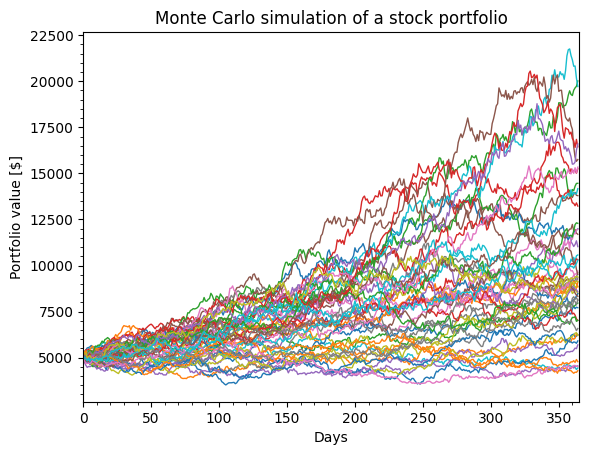

In [15]:
plt.plot(portfolio_sims, '-', linewidth=1)
plt.ylabel('Portfolio value [$]')
plt.xlabel('Days')
plt.title('Monte Carlo simulation of a stock portfolio')
plt.xlim(0,T)
plt.savefig('MC_simulation_stock_portfolio.png', dpi=250)
plt.minorticks_on()
plt.show()

mkdir: frames: File exists


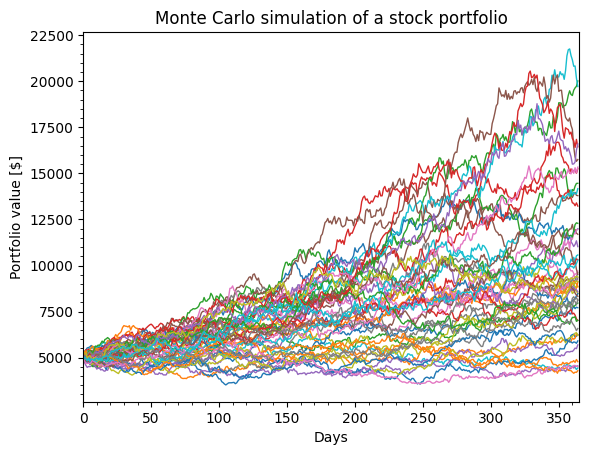

In [16]:
# make png files for movie
!mkdir frames

for i in range(portfolio_sims.shape[1]): 
    plt.plot(portfolio_sims[:,i], '-', linewidth=1)
    plt.ylabel('Portfolio value [$]')
    plt.xlabel('Days')
    plt.xlim(0,T)
    plt.title('Monte Carlo simulation of a stock portfolio')
    plt.savefig('MC_simulation_stock_portfolio.png',dpi=250)
    plt.minorticks_on()
    plt.savefig(f'{path}/frames/frames_{i:05}.png')
    #print(f'{path}/frames/frames_{i:05}.png')

In [17]:
!ffmpeg -framerate 10 -i frames/frames_%05d.png -c:v libx264 -r 30 -pix_fmt yuv420p frames/movie.mp4
#rm frames/*.png

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disab